In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from haversine import haversine

In [2]:
# Load the dataset
data = pd.read_csv("train.csv")

# Display basic information about the dataset
print("Dataset Info:")
data.info()

# Display first few rows
data.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
# Handling missing values
print("Missing values per column:")
print(data.isnull().sum())
data = data.dropna()

# Handling outliers
# Removing unrealistic fare amounts
data = data[(data['fare_amount'] > 0) & (data['fare_amount'] < 250)]

# Removing unrealistic passenger counts
data = data[(data['passenger_count'] > 0) & (data['passenger_count'] <= 6)]

# Removing trips with invalid coordinates
NYC_LAT_MIN, NYC_LAT_MAX = 40.477399, 40.917577
NYC_LON_MIN, NYC_LON_MAX = -74.259090, -73.700272

# Filter trips within NYC bounds
data = data[
    (data['pickup_latitude'] >= NYC_LAT_MIN) & (data['pickup_latitude'] <= NYC_LAT_MAX) &
    (data['pickup_longitude'] >= NYC_LON_MIN) & (data['pickup_longitude'] <= NYC_LON_MAX) &
    (data['dropoff_latitude'] >= NYC_LAT_MIN) & (data['dropoff_latitude'] <= NYC_LAT_MAX) &
    (data['dropoff_longitude'] >= NYC_LON_MIN) & (data['dropoff_longitude'] <= NYC_LON_MAX) &
    (data['pickup_latitude'] != 0) & (data['pickup_longitude'] != 0) &
    (data['dropoff_latitude'] != 0) & (data['dropoff_longitude'] != 0)
]

print(f"Dataset size after cleaning: {data.shape}")


Missing values per column:
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64
Dataset size after cleaning: (48706, 8)


In [4]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,48706.000000,48706.000000,48706.000000,48706.000000,48706.000000,48706.000000
mean,11.315764,-73.975569,40.750871,-73.974377,40.751362,1.674989
std,9.387540,0.034243,0.026922,0.034107,0.030702,1.289228
min,0.010000,-74.248263,40.522263,-74.241953,40.484335,1.000000
25%,6.000000,-73.992317,40.736522,-73.991337,40.735929,1.000000
50%,8.500000,-73.982132,40.753421,-73.980511,40.754098,1.000000
75%,12.500000,-73.968445,40.767720,-73.965447,40.768436,2.000000
max,165.000000,-73.702795,40.891938,-73.701188,40.911983,6.000000


In [5]:
# Convert pickup_datetime to datetime
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

# Extract time-based features
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_day'] = data['pickup_datetime'].dt.day
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday
data['pickup_month'] = data['pickup_datetime'].dt.month

# Calculate distance using the Haversine formula
def calculate_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(pickup, dropoff)

data['distance_km'] = data.apply(calculate_distance, axis=1)

# Display processed data
data.head()


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_day,pickup_weekday,pickup_month,distance_km
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,0,6,1.030765
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,1,8.450145
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,3,8,1.389527
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,5,4,2.799274
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,1,3,1.999160


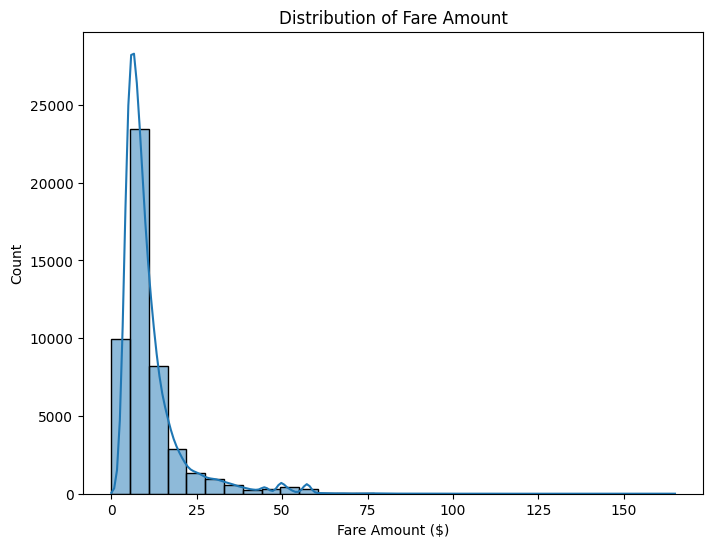

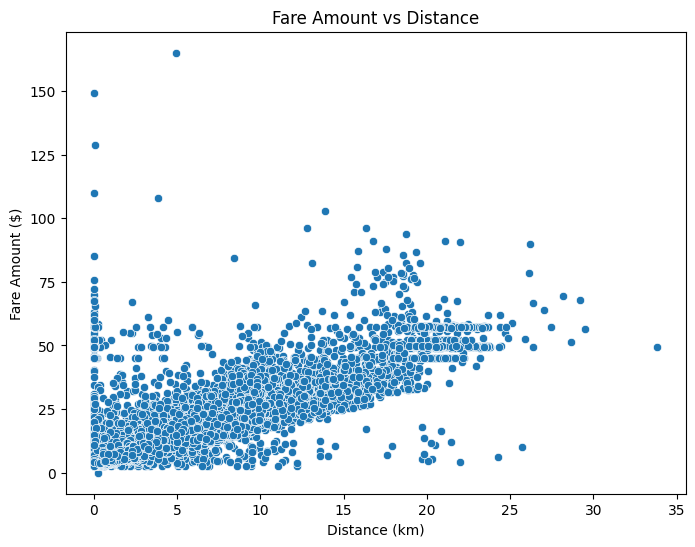

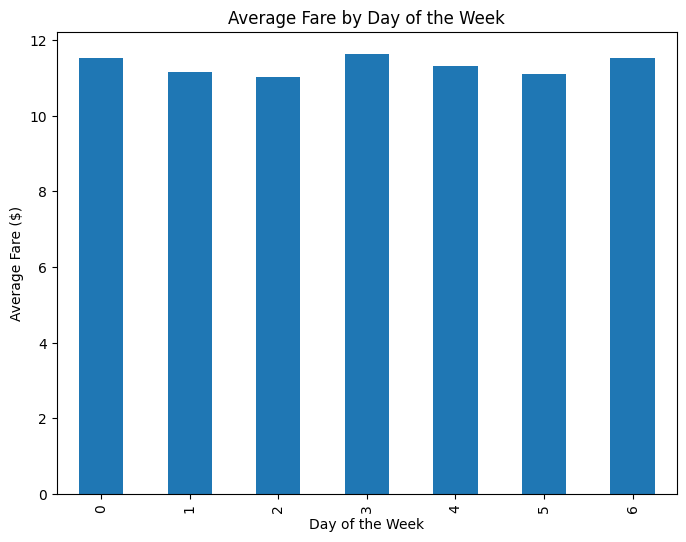

In [6]:
# Visualizing fare amount distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['fare_amount'], bins=30, kde=True)
plt.title("Distribution of Fare Amount")
plt.xlabel("Fare Amount ($)")
plt.show()

# Visualizing distance vs fare
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['distance_km'], y=data['fare_amount'])
plt.title("Fare Amount vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount ($)")
plt.show()

# Average fare by day of the week
average_fare_weekday = data.groupby('pickup_weekday')['fare_amount'].mean()
average_fare_weekday.plot(kind='bar', figsize=(8, 6))
plt.title("Average Fare by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Fare ($)")
plt.show()


In [7]:
# Define the Haversine formula for calculating distances
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Define Manhattan distance function
def manhattan(lat1, lon1, lat2, lon2):
    return haversine(lat1, lon1, lat1, lon2) + haversine(lat1, lon2, lat2, lon2)

# Define Euclidean distance
def euclidean(lat1, lon1, lat2, lon2):
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)


In [8]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

# Extract time-related features
data['pickup_year'] = data['pickup_datetime'].dt.year
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_day'] = data['pickup_datetime'].dt.day
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday

# Define night and late-night flags
data['night'] = ((data['pickup_hour'] >= 16) & (data['pickup_hour'] <= 20) & (data['pickup_weekday'] < 5)).astype(int)
data['late_night'] = ((data['pickup_hour'] >= 20) | (data['pickup_hour'] <= 6)).astype(int)


In [9]:
# Latitude and longitude differences
data['lat_diff'] = data['dropoff_latitude'] - data['pickup_latitude']
data['lon_diff'] = data['dropoff_longitude'] - data['pickup_longitude']


In [10]:
# Add distances using the helper functions
data['haversine_distance'] = haversine(
    data['pickup_latitude'], data['pickup_longitude'],
    data['dropoff_latitude'], data['dropoff_longitude']
)

data['euclidean_distance'] = euclidean(
    data['pickup_latitude'], data['pickup_longitude'],
    data['dropoff_latitude'], data['dropoff_longitude']
)

data['manhattan_distance'] = manhattan(
    data['pickup_latitude'], data['pickup_longitude'],
    data['dropoff_latitude'], data['dropoff_longitude']
)

# Define hotspot coordinates (approximate)
hotspots = {
    "JFK": (40.6413, -73.7781),
    "EWR": (40.6895, -74.1745),
    "LGA": (40.7769, -73.8740),
    "Downtown": (40.7128, -74.0060)
}

# Calculate Manhattan distances to hotspots
for name, coords in hotspots.items():
    data[f'manhattan_to_{name}_pickup'] = manhattan(
        data['pickup_latitude'], data['pickup_longitude'],
        coords[0], coords[1]
    )
    data[f'manhattan_to_{name}_dropoff'] = manhattan(
        data['dropoff_latitude'], data['dropoff_longitude'],
        coords[0], coords[1]
    )
